In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))

In [4]:
from utils import *

# Loading Data

In [3]:
df = pd.read_csv('../data/raw/Copy of BrentOilPrices (1).csv')

In [3]:
df.head()

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


## Understanding the data

In [4]:
df.shape

(9011, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [6]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [5]:
column_summary(df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Date,object,0,9011,9011,"{'20-May-87': 1, '12-Jan-11': 1, '04-Jan-11': ..."
1,Price,float64,0,9011,5015,"{18.48: 26, 18.15: 22, 16.85: 20, 18.63: 18, 1..."


In [6]:

# Reset the index to bring 'Date' back as a column
df.reset_index(inplace=True)

## convert the data into a pandas dataframe

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_6040\2394721818.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


In [11]:
# Extract year, month, and day features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day


## Check for outliers

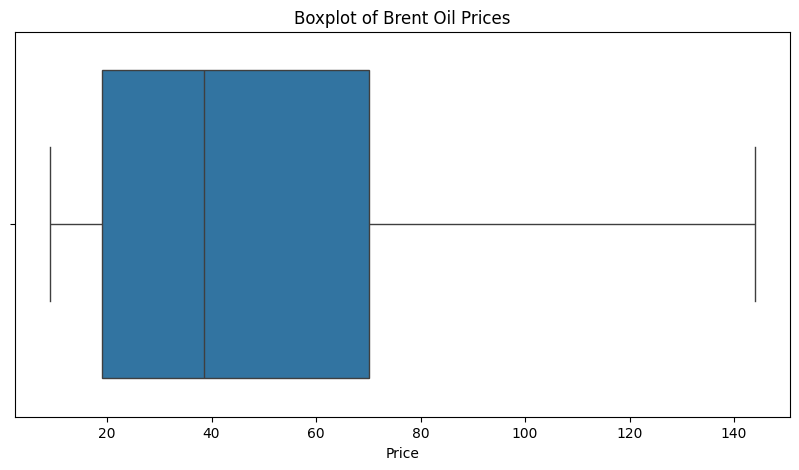

In [12]:

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Price'])
plt.title('Boxplot of Brent Oil Prices')
plt.show()

## Plotting the time series data

In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

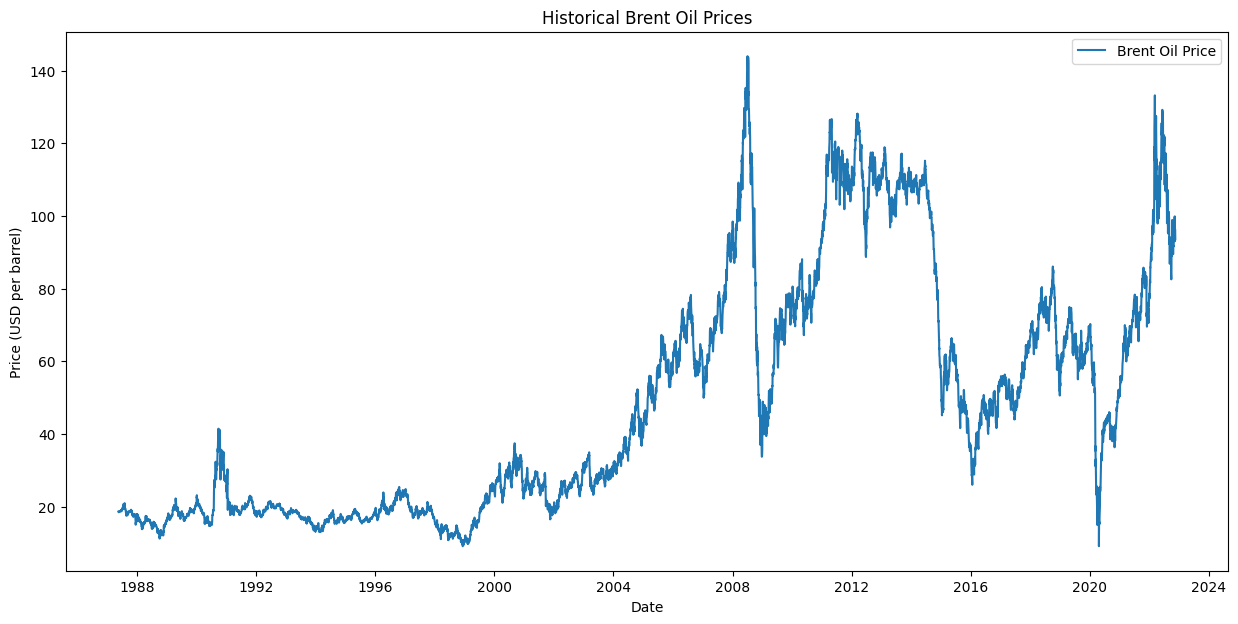

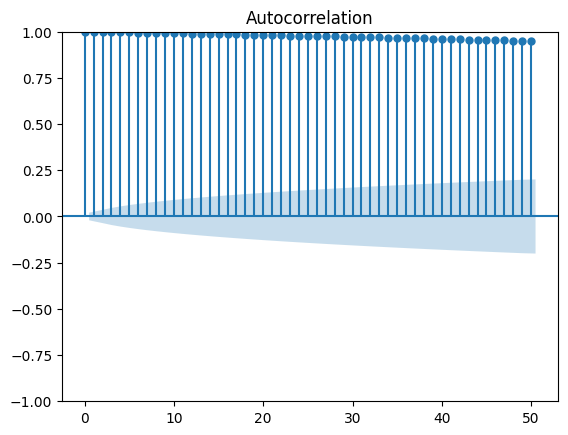

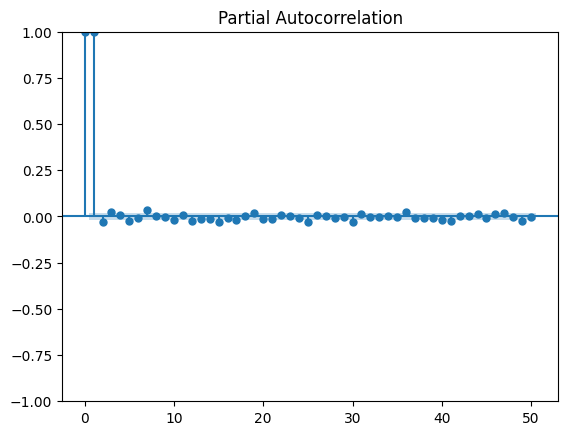

ADF Statistic: -1.9938560113924668
p-value: 0.2892735048934032


In [15]:
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Price'], label='Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Historical Brent Oil Prices')
plt.legend()
plt.show()

# ACF and PACF plots
plot_acf(df['Price'], lags=50)
plot_pacf(df['Price'], lags=50)
plt.show()

# Check stationarity
result = adfuller(df['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

## Histogram: Distribution of oil prices

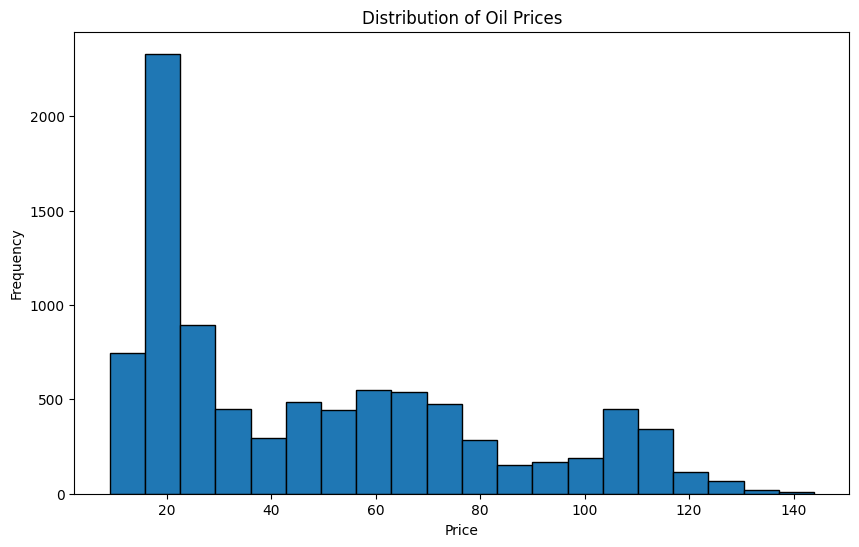

In [16]:
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=20, edgecolor='black')
plt.title('Distribution of Oil Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## Bar Chart: Average Price by Year

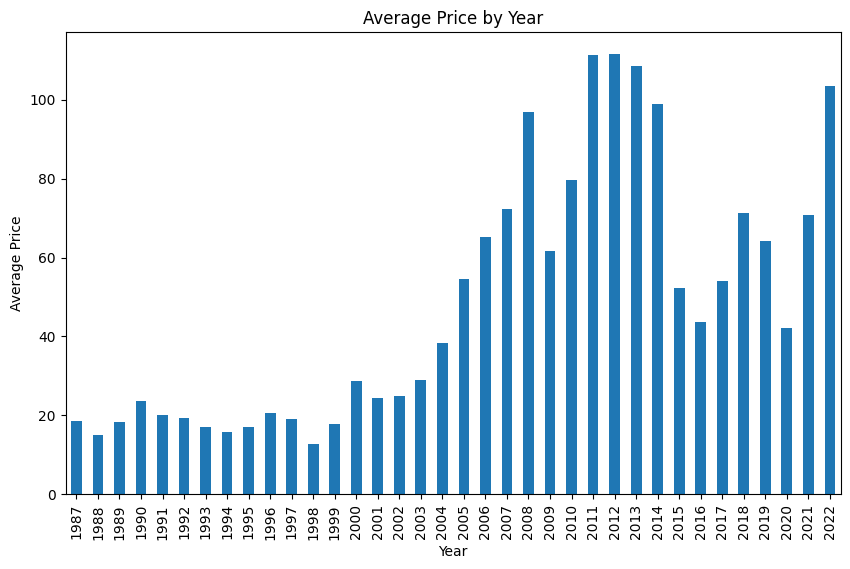

In [17]:
avg_price_per_year = df.groupby('Year')['Price'].mean()
plt.figure(figsize=(10, 6))
avg_price_per_year.plot(kind='bar')
plt.title('Average Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.show()

In [18]:
from pmdarima import auto_arima

In [19]:
# Apply differencing to make the series stationary
df['Price_diff'] = df['Price'].diff().dropna()

# Fit the ARIMA model
model = auto_arima(df['Price_diff'].dropna(), seasonal=False, trace=True)
model.summary()

# Fit the model with ARIMA parameters
arima_model = ARIMA(df['Price'], order=(5, 1, 0))
arima_result = arima_model.fit()
print(arima_result.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29075.828, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29098.172, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=29094.409, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=29094.124, Time=0.54 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29093.231, Time=2.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=29093.013, Time=3.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=13.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=12.80 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=29093.899, Time=0.57 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=29094.073, Time=4.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29094.084, Time=2.28 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=29077.815, Time=15.78 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29077.401, Time=12.71 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 75.750 seconds
                

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
# Calculate metrics
# Predictions
pred = arima_result.predict(start=len(df), end=len(df) + 30, typ='levels')
mse = mean_squared_error(df['Price'][-30:], pred[:30])
mae = mean_absolute_error(df['Price'][-30:], pred[:30])
print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 6.927581933434591
MAE: 2.051611949881855


c:\brent-oil-statistical-modelling\venv\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


##  Plot predictions

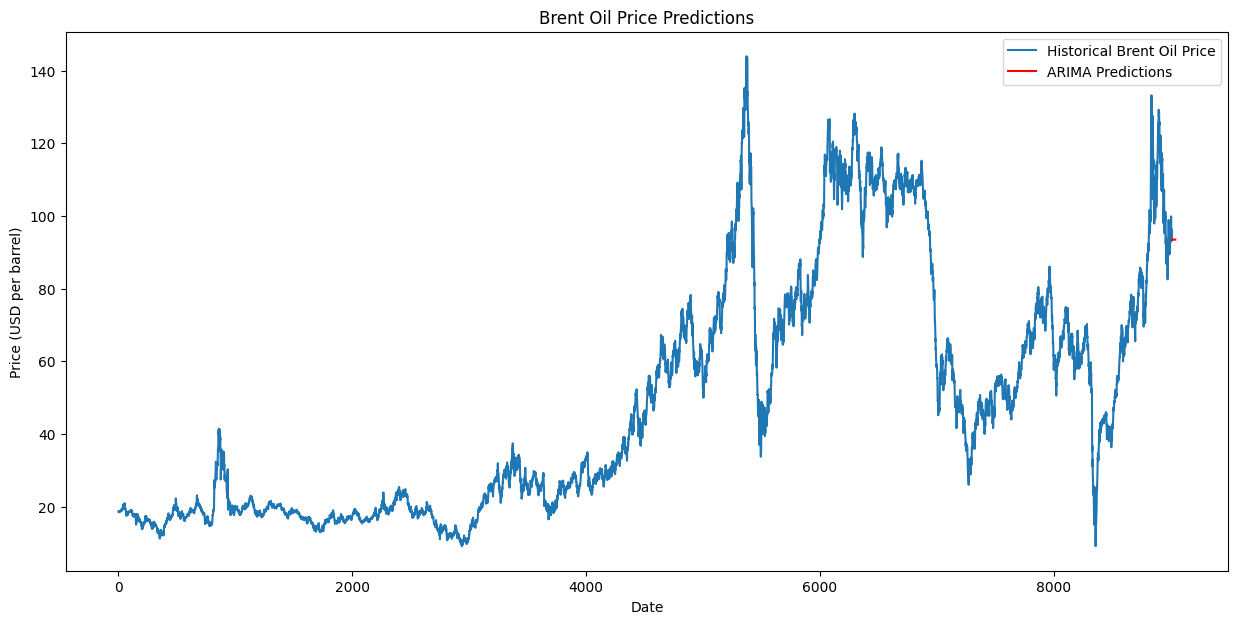

In [22]:

plt.figure(figsize=(15, 7))
plt.plot(df['Price'], label='Historical Brent Oil Price')
plt.plot(pred, label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.title('Brent Oil Price Predictions')
plt.legend()
plt.show()